In [15]:
# luca-cnv python kernel

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches


class Genome():
  CHUNK = 100000  # 0.1 mb
  
  # https://www.ncbi.nlm.nih.gov/grc/human/data
  # Using "placed scaffolds" as operative metric
  _chrom_sizes = {
        1: 248_956_422,
        2: 242_193_529,
        3: 198_295_559,
        4: 190_214_555,
        5: 181_538_259,
        6: 170_805_979,
        7: 159_345_973,
        8: 145_138_636,
        9: 138_394_717,
        10: 133_797_422,
        11: 135_086_622,
        12: 133_275_309,
        13: 114_364_328,
        14: 107_043_718,
        15: 101_991_189,
        16: 90_338_345,
        17: 83_257_441,
        18: 80_373_285,
        19: 58_617_616,
        20: 64_444_167,
        21: 46_709_983,
        22: 50_818_468,
        'X': 156_040_895,
        'Y': 57_227_415  
  }
  
  def __init__(self):
    self.windows = self.make_genome_row()
  
  def make_genome_row(self):
    res = []
    
    for chrom, size in self._chrom_sizes.items():
      if chrom not in ['X', 'Y']:
        
        n_whole_chunks = size // self.CHUNK
        for block in range(n_whole_chunks):
          start = 1 + self.CHUNK*block
          end = start + self.CHUNK - 1
          res.append({'chr': chrom, 'start': start, 'end': end})
        
        # Final incomplete chunk
        start = 1 + self.CHUNK*n_whole_chunks
        end = start + (size % self.CHUNK) - 1
        res.append({'chr': chrom, 'start': start, 'end': end})
        
    out = pd.DataFrame(res)
    out['window'] = out[['chr', 
                         'start', 
                         'end']].astype(str).agg('_'.join, axis=1)
    out['winsize'] = out.end - out.start + 1
    return out
  
  def assign_range_values(self, chr, start, end):
    '''
    Given a chromosome and a range, gives us the window names and their 
    fractional occupation levels. Converts from arbitrary ranges to
    pre-defined windows of 1MB chunk size
    '''
    first_chunk = 1 + self.CHUNK*((start-1) // self.CHUNK)
    last_chunk = 1 + self.CHUNK*((end-1) // self.CHUNK)
    
    first_window = self.windows[(self.windows.chr == chr) & 
                                (self.windows.start == first_chunk)]
    last_window = self.windows[(self.windows.chr == chr) & 
                               (self.windows.start == last_chunk)]
    
    assert end >= start, 'End must be >= start'
    errmsg = (f'Coordinates must be within limits. '
              f'For chromosome {chr}, max size is '
              f'{self._chrom_sizes[chr]:,}.')
    assert start > 0 and end <= list(last_window.end)[0], errmsg
    
    if first_window.index == last_window.index:
      window_frac = (end - start + 1) / first_window.winsize
      fracs =  {list(first_window.window)[0]: window_frac}
    else:
      all_windows = (self.windows
                     .iloc[first_window.index[0]:
                           last_window.index[0]+1].window)
      fracs = {w: 1.0 for w in all_windows}
      fracs[list(all_windows)[0]] = list((first_window.end - start + 1) / 
                                         first_window.winsize)[0]
      fracs[list(all_windows)[-1]] = list((end - last_window.start + 1) / 
                                          last_window.winsize)[0]
    return fracs


class CNVMap():
  cnv_quantized = {'amp': 2, 'bamp': 1, 'loh': 0, 'bdel':-1, 'del': -2}

  def __init__(self, csv):
    self.df = self.process_csv(csv)
    self.genome = Genome()
    self.agg_matrix = self.make_agg_matrix()
    self.agg_pct_matrix = self.make_agg_pct_matrix()
    
    
  def process_csv(self, csv):
    df = pd.read_csv(csv, sep=',', index_col=0)
    df = df[~np.isnan(df.clones)]
    df.clones = df.clones.astype(int)
    df = df[df.clones != 0]
    # `cnv_state` and `cnv_state_post` appear identical
    # `cnv_states` differs from the other two.
    # Som says to use `cnv_state` for analysis
    df = df[['sample', 'PT_BM', 'clones', 'CHROM', 'cnv_state', 
             'cnv_state_post', 'seg_start', 'seg_end', 
             'cnv_states', 'mean_cnv']]
    return df
  
  def make_agg(self, df_subset):
    # Each subset should be the df subsetted to a sample-clone pairing
    # eg `tmp.df[(tmp.df['sample'] == 'KRAS_17') & (tmp.df.clones == 1)]`
    window_scaffold = {k: None for k in self.genome.windows.window}
    for i, row in df_subset.iterrows():
      chrom = int(row.CHROM)
      start = int(row.seg_start)
      end = int(row.seg_end)
      state = self.cnv_quantized.get(row.cnv_state)
      
      # For visualization, we will ignore the fractional window occupancy
      # and just count it if there is nonzero occupancy
      fracs = self.genome.assign_range_values(chrom, start, end)
      for wname, alpha in fracs.items():
        window_scaffold[wname] = state
    return window_scaffold
  
  def make_agg_matrix(self):
    rows = []
    for samplename, subset in tqdm(self.df.groupby(['sample']),
                              "Summarizing each sample's CNVs"):
      # First append empty scaffold for spacing
      new_row = pd.DataFrame.from_dict({k: None 
                                        for k in self.genome.windows.window},
                                       orient='index').transpose()
      n_clones = len(subset.clones.unique())
      new_row.index = [f'{samplename[0]}: {n_clones} clones']
      rows.append(new_row)
      
      for clone, subset2 in subset.groupby(['clones']):
        smpl_clone = f'{samplename[0]}_clone{clone[0]}'
        sample_agg = self.make_agg(subset2)
        new_row = pd.DataFrame.from_dict(sample_agg, orient='index').transpose()
        new_row.index = [smpl_clone]
        rows.append(new_row)
        
    return pd.concat(rows)
  
  def make_agg_pct_matrix(self):
    assert self.agg_matrix is not None, 'Must first call `make_agg_matrix()`'
    mat = self.agg_matrix.copy()
    window_names = mat.columns
    mat.columns = list(range(len(window_names)))
    
    empty_rows = [i for i in self.agg_matrix.index if i.endswith(' clones')]
    n_total_clones = mat.shape[0] - len(empty_rows)

    value_counts_dict = {}
    for window in tqdm(mat.columns, 'Calculating stats for each genome window'):
        counts = mat[window].value_counts(dropna=True)
        value_counts_dict[window] = counts
    value_counts_df = pd.DataFrame(value_counts_dict)
    percentage_df = value_counts_df / n_total_clones
    percentage_df[np.isnan(percentage_df)] = 0 

    return percentage_df
  
  def make_agg_plot(self, title, height_ratios, 
                    height=10, width=10, dry_run=False):
    window_names = self.agg_matrix.columns
    mat = self.agg_matrix
    
    # Dry run: Plot only first 500 agg vals to ensure plot is correct shape.
    # Use this while you play with values of `height_ratios` to ensure the
    # final plot looks roughly correct.
    # This is because the bar plot takes forever if you include all values
    if dry_run:  
      pct_mat = self.agg_pct_matrix.loc[:, 1:500]
    else:
      pct_mat = self.agg_pct_matrix
    
    # Define our custom cmap
    conds = ['del', 'bdel', 'loh', 'bamp', 'amp']
    quantized_values = [self.cnv_quantized.get(cond) for cond in conds]
    colors = ['#d7191c','#fdae61','#707070','#abd9e9','#2c7bb6'][::-1]
    norm = plt.Normalize(min(quantized_values), max(quantized_values))
    color_points = [(norm(value), color) 
                    for value, color in zip(quantized_values, colors)]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", color_points)
    cmap_dict = {v: c for v, c in zip(quantized_values, colors)}

    
    (fig, ax) = plt.subplots(3, 1, 
                             figsize=(width, height), 
                             height_ratios=height_ratios)
    
    # Main heatmap
    hm = sns.heatmap(mat, cmap=cmap, 
                cbar_kws = dict(use_gridspec=False,location='right'),
                cbar=False, ax=ax[1])
      
    # Aggregation bar plot
    cum_vals=0
    for idx in tqdm(pct_mat.index, 'Aggregate plot for each CNV type'):
        cur_vals = pct_mat.loc[idx]
        cnv_color = cmap_dict[int(idx)]
        ax[0].bar(pct_mat.columns, cur_vals, 
                bottom = cum_vals, width=1.0, 
                align='center', color=cnv_color)
        cum_vals += cur_vals
    # Plurality consensus
    plurality = pct_mat.idxmax()
    ax[0].bar(plurality.index, 0.1, bottom=1.0, width=1.0, 
                  color=[cmap_dict[val] for val in plurality])

    # Tick positions
    x_labels = [label.split('_')[0] if '_1_' in label else '' 
                for label in window_names]
    y_labels = [label if label.endswith(' clones') else '' 
                for label in mat.index]
    
    ax[1].tick_params(top=False, labeltop=False, 
                   bottom=True, labelbottom=True, 
                   left=True, labelleft=True, 
                   right=False, labelright=False)
    ax[1].set_xticks([x_labels.index(str(i)) for i in range(1, 23)], 
                  labels = list(range(1,23)), rotation='vertical')
    ax[1].set_yticks([i for i, v in enumerate(y_labels) if v != ''], 
                  labels = [v for i, v in enumerate(y_labels) if v != ''])
    ax[1].set_yticks([i for i, v in enumerate(y_labels) if v == ''], 
                  labels = [v for i, v in enumerate(y_labels) if v == ''], 
                  minor=True)
    ax[1].tick_params(which='major', length=6, width=1.3)
    ax[1].tick_params(which='minor', length=2, width=1)
    
    ax[0].set_xlim(0, len(window_names))
    ax[0].set_xticks([])
    ax[0].set_ylim(0, 1.1)
    ax[0].set_yticks([0 , 0.5, 1])
    ax[0].set_yticks([0.25, 0.75], minor=True)
    ax[0].tick_params(which='major', length=6, width=1.3)
    ax[0].tick_params(which='minor', length=2, width=1)

    # Add separation lines
    for i, txt in enumerate(y_labels):
      if txt != '' or i == len(y_labels)-1:
        ax[1].hlines(xmin=0, xmax=mat.shape[1], y=i, 
                  color='black', lw=0.5, ls=':') 
    for val in [0.25, 0.5, 0.75]:
      ax[0].hlines(xmin=0, xmax=len(window_names), y=val, 
                   color='black', lw=0.2, ls=':')
    for i, txt in enumerate(self.agg_matrix.columns):
      if '_1_' in txt or i == len(self.agg_matrix.columns)-1:
        ax[0].vlines(ymin=0, ymax=1, x=i, 
                  color='black', lw=0.5, ls=':') 
        ax[1].vlines(ymin=0, ymax=mat.shape[0], x=i, 
                  color='black', lw=0.5, ls=':') 
        
    # Legend as manual patches
    patches = [mpatches.Patch(color=colors[i], label=conds[i]) 
              for i, _ in enumerate(quantized_values)]
    ax[2].legend(handles=patches, fancybox=True, shadow=True, ncol=5,
                bbox_to_anchor=(0.5,0), loc='upper center')
    ax[2].axis('off')  # Just a "spacer" axis
        
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0)
    fig.show()
    
    self.agg_plot = fig
    return fig


Summarizing each sample's CNVs: 100%|██████████| 11/11 [00:01<00:00,  7.75it/s]
/tmp/ipykernel_1680/1423622493.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(rows)
Aggregate plot for each CNV type: 100%|██████████| 4/4 [01:19<00:00, 19.95s/it]


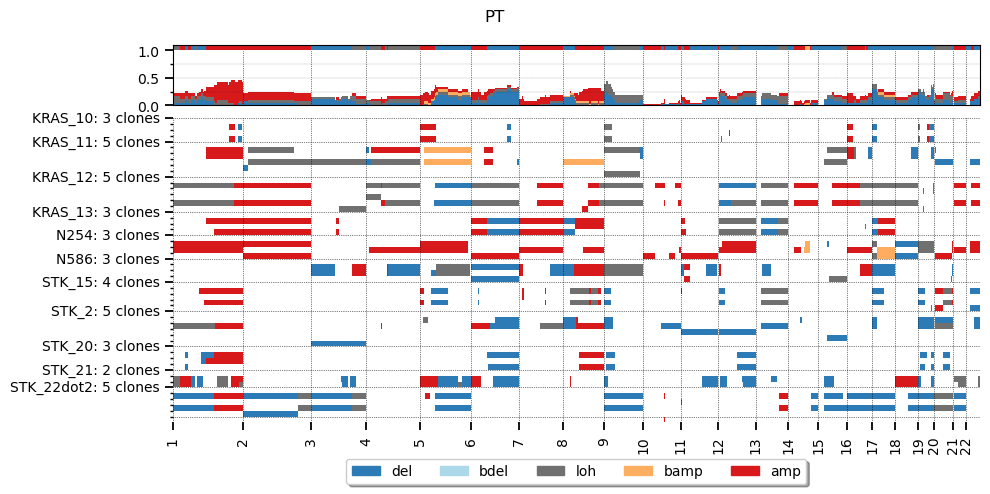

In [18]:
pt = CNVMap('/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/PT.samples.clones.csv')  # CSV from Numbat output
pt_plot = pt.make_agg_plot('PT', height_ratios = [2, 10, 0.55],
                         height=5, width=10, dry_run=False)

Summarizing each sample's CNVs: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]
/tmp/ipykernel_1680/1423622493.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(rows)
Aggregate plot for each CNV type: 100%|██████████| 5/5 [01:33<00:00, 18.70s/it]


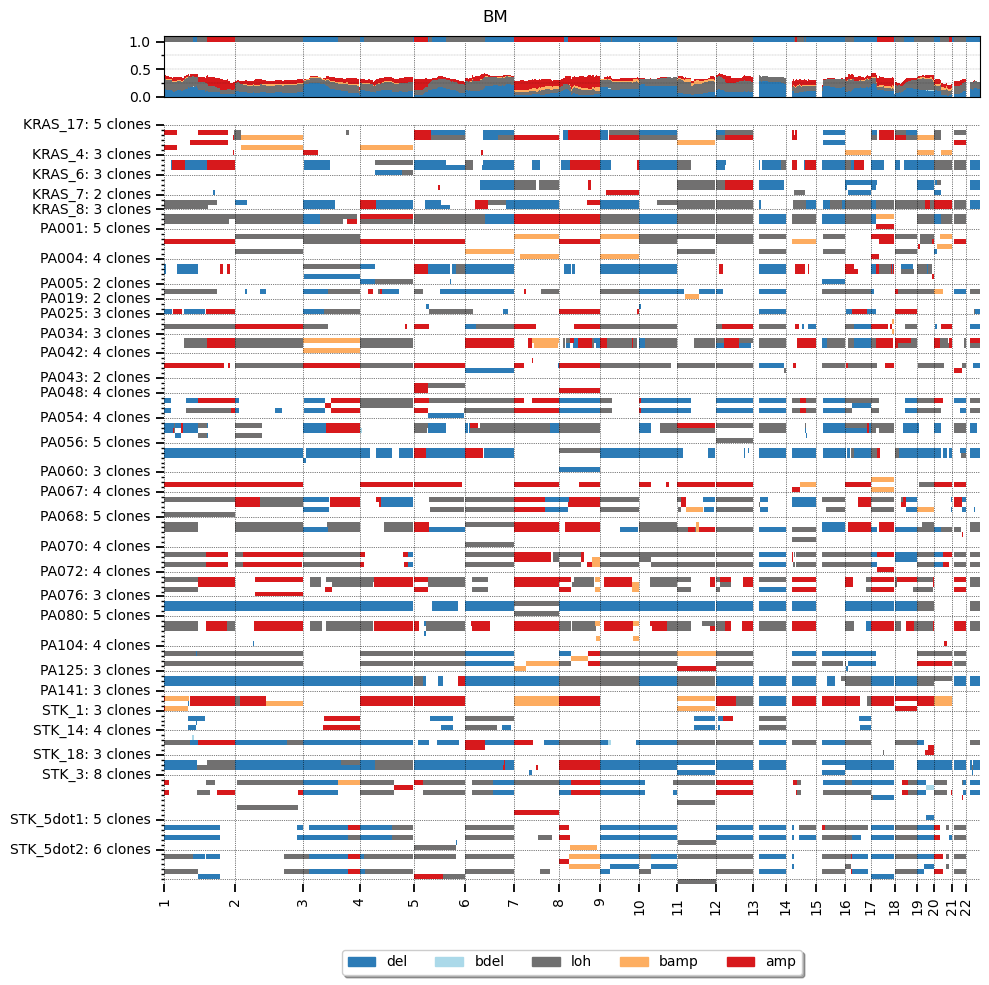

In [19]:
bm = CNVMap('/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/BM.samples.clones.csv')
bm_plot = bm.make_agg_plot('BM', height_ratios = [0.8, 10, 0.4],
                         height=10, width=10, dry_run=False)

In [7]:
pt.agg_pct_matrix.sum().mean()

0.20207096577224468

In [8]:
bm.agg_pct_matrix.sum().mean()

0.3289144128093427

In [12]:
from scipy.stats import wilcoxon
wilcoxon(bm.agg_pct_matrix.sum(), pt.agg_pct_matrix.sum())

WilcoxonResult(statistic=11356050.0, pvalue=0.0)

In [20]:
pt_plot.savefig('/home/ubuntu/tmp/pt_plot.pdf')
print('Finished PT')
bm_plot.savefig('/home/ubuntu/tmp/bm_plot.pdf')
print('Finished BM')

Finished PT
Finished BM
